In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

In [42]:
data_dir='levelups_panel_0920_filled.csv'
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
0,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
1,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
2,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
3,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
4,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720616,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720617,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720618,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720619,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [43]:
# player_slug의 고유 값 수 계산
unique_player_count = data['player_slug'].nunique()

# 결과 출력
print(unique_player_count)

7279


In [44]:
data.columns

Index(['player_slug', 'character_slug', 'first_session_level', 'binger',
       'total_purchase', 'total_ad', 'highest_level', 'status', 'level_from',
       'level_to', 'event_datetime', 'death', 'ad_revival', 'ad_item',
       'ad_total', 'purchase', 'event_datetime_prev', 'interval',
       'interval_cum', 'playtime_boss', 'playtime_dungeon', 'playtime_tower',
       'playtime_pvp', 'playtime_farm', 'playtime_survival', 'playtime_side',
       'date_event', 'date_event_prev', 'same_date', 'date_interval', 'binge'],
      dtype='object')

## level_to 별 interval

In [45]:
# 'level_to' 값별로 'date_interval' 값의 평균 계산
level_to_interval_avg = data.groupby('level_to')['interval'].mean()


In [46]:
level_to_interval_avg

level_to
2      0.016041
3      0.007325
4      0.015447
5      0.018114
6      0.026735
         ...   
96     0.095358
97     0.050302
98     0.081802
99     0.189034
100    0.250430
Name: interval, Length: 99, dtype: float64

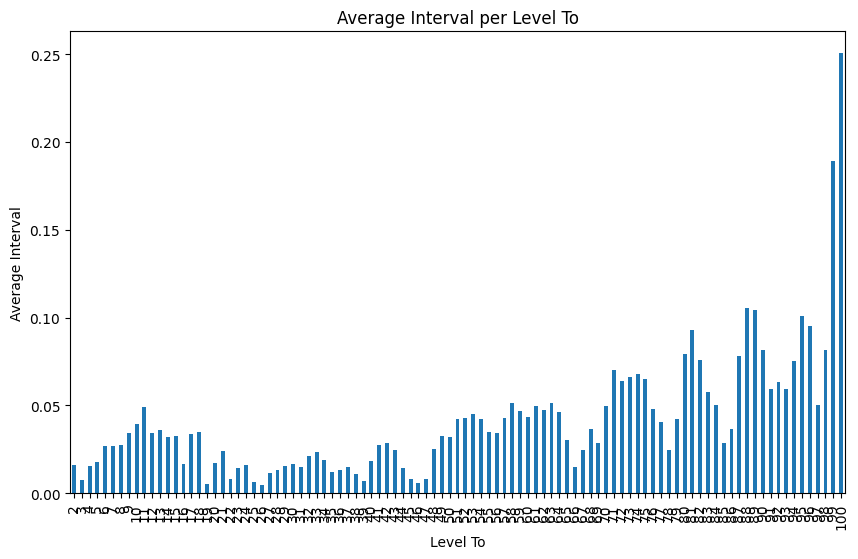

In [47]:
import matplotlib.pyplot as plt

# 바 플롯 생성
plt.figure(figsize=(10, 6))
level_to_interval_avg.plot(kind='bar')

# 플롯에 라벨과 제목 설정
plt.xlabel('Level To')
plt.ylabel('Average Interval')
plt.title('Average Interval per Level To')

# 플롯 출력
plt.show()

In [48]:
# 'level_to'를 10 단위로 구간화
data['level_to_by_10'] = pd.cut(data['level_to'], bins=range(0, int(data['level_to'].max()) + 10, 10))
# 구간화된 'level_to_bins'을 기준으로 'interval'의 평균 계산
level_to_interval_avg = data.groupby('level_to_by_10')['interval'].mean()
level_to_interval_avg

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_18748\924240443.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  level_to_interval_avg = data.groupby('level_to_by_10')['interval'].mean()


level_to_by_10
(0, 10]      0.023518
(10, 20]     0.029271
(20, 30]     0.013105
(30, 40]     0.015662
(40, 50]     0.020768
(50, 60]     0.042612
(60, 70]     0.037970
(70, 80]     0.056860
(80, 90]     0.071122
(90, 100]    0.102562
Name: interval, dtype: float64

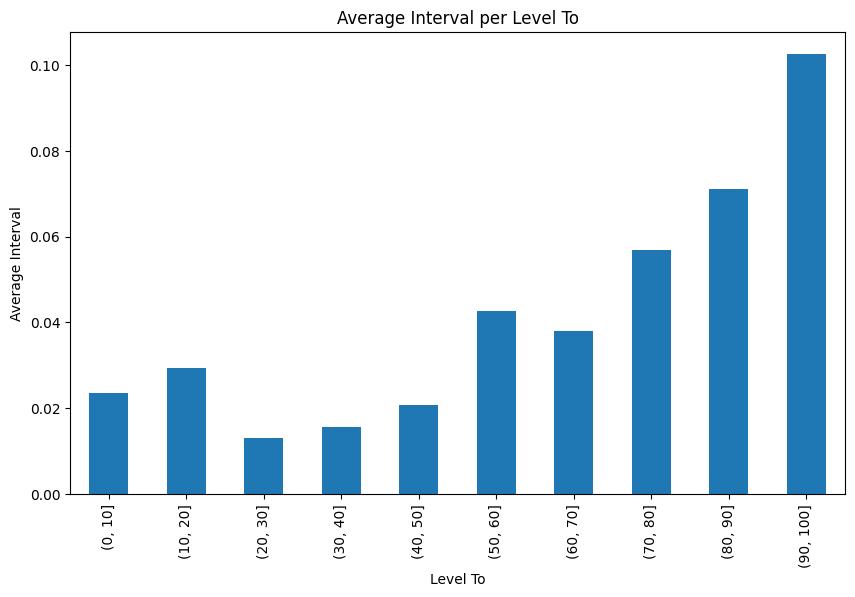

In [50]:
import matplotlib.pyplot as plt

# 바 플롯 생성
plt.figure(figsize=(10, 6))
level_to_interval_avg.plot(kind='bar')

# 플롯에 라벨과 제목 설정
plt.xlabel('Level To')
plt.ylabel('Average Interval')
plt.title('Average Interval per Level To')

# 플롯 출력
plt.show()

## 하루만 게임하고 그 뒤로는 하지 않은 사람

In [36]:
# 'date_event'가 하루만 있는 사람들을 찾기 위해 각 player_slug에 대해 date_event의 고유 값 개수를 계산
single_day_players = data.groupby('player_slug')['date_event'].nunique()

# 하루만 있는 사람들 필터링
single_day_players = single_day_players[single_day_players == 1]

# 해당 플레이어 데이터를 원래 데이터에서 필터링
single_day_data = data[data['player_slug'].isin(single_day_players.index)]

# 결과 출력
single_day_data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
99,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
100,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
101,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
102,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
103,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720616,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720617,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720618,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
720619,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [37]:
# player_slug의 고유 값 수 계산
unique_player_count = single_day_data['player_slug'].nunique()

# 결과 출력
print(unique_player_count)

2151


In [38]:
multi_day_data = data[~data['player_slug'].isin(single_day_players.index)]


## 하루만 한 사람과 아닌 사람들의 플레이 시간 비교

In [39]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot'] = multi_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
multi_day_data['interval_normalized'] = multi_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until_norm'] = multi_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot_norm'] = multi_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_multi = multi_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\657298615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\657298615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\657298615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [40]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot'] = single_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
single_day_data['interval_normalized'] = single_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until_norm'] = single_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot_norm'] = single_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_single = single_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\3484137446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\3484137446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_35068\3484137446.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [41]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg = df_last_single['interval_tot'].mean()

# 결과 출력
print(interval_avg)


3.404934474921221


In [42]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg_multi = df_last_multi['interval_tot'].mean()

# 결과 출력
print(interval_avg_multi)


4.40715938637545


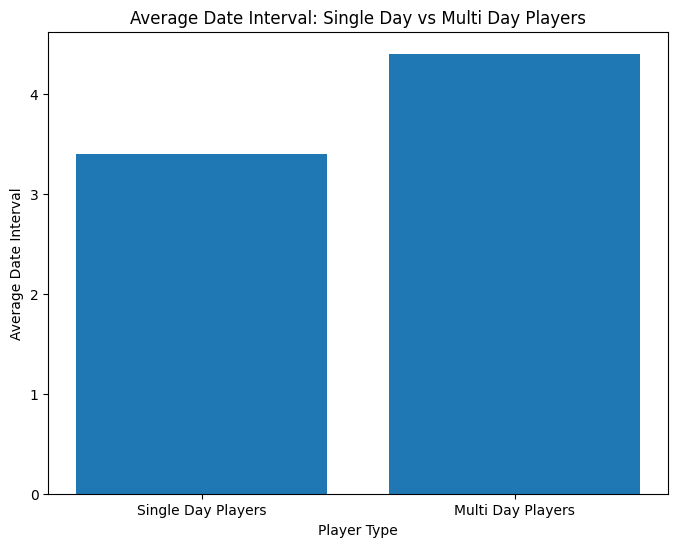

In [43]:
import matplotlib.pyplot as plt

# 두 그룹의 평균 값
intervals = [interval_avg, interval_avg_multi]
labels = ['Single Day Players', 'Multi Day Players']

# 바 플롯 생성
plt.figure(figsize=(8, 6))
plt.bar(labels, intervals)

# 플롯 라벨과 제목 설정
plt.xlabel('Player Type')
plt.ylabel('Average Date Interval')
plt.title('Average Date Interval: Single Day vs Multi Day Players')

# 그래프 출력
plt.show()


## 몇번 게임을 했는지

In [52]:
data_dir='levelups_panel_0920_filled.csv'
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]

In [55]:
# 'date_event'가 하루만 있는 사람들을 찾기 위해 각 player_slug에 대해 date_event의 고유 값 개수를 계산
single_day_players = data.groupby('player_slug')['date_event'].nunique()
frequency_counts = single_day_players.value_counts()


In [58]:
frequency_counts

date_event
2     2954
1     2151
3     1154
4      498
5      245
6      122
7       64
8       32
9       18
10      14
11      12
13       5
12       3
14       2
17       1
23       1
21       1
18       1
15       1
Name: count, dtype: int64

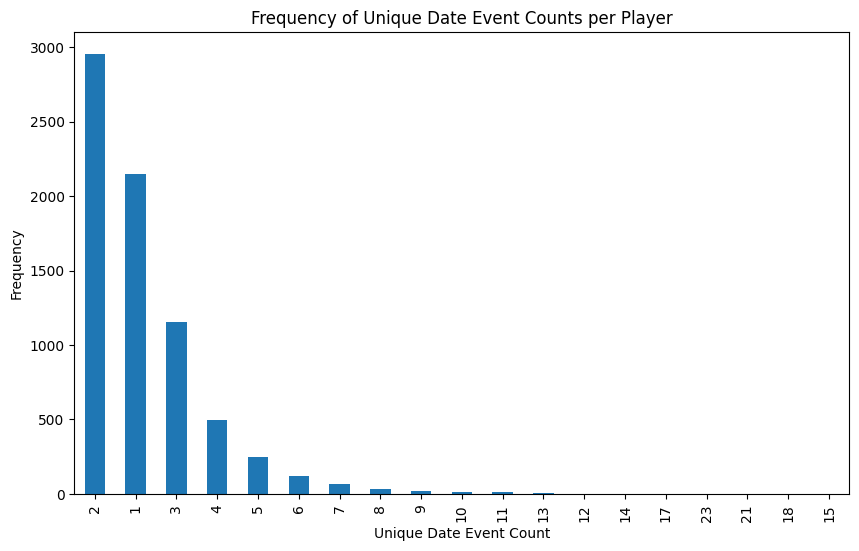

In [57]:
# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Frequency of Unique Date Event Counts per Player')
plt.xlabel('Unique Date Event Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

## 실제 시간 계산을 통한 실제 시간 중 게임에 사용한 시간 비율 계산

In [5]:
data_dir='levelups_panel_0920_filled.csv'
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]

In [6]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot'] = data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['interval_normalized'] = data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until_norm'] = data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot_norm'] = data.groupby('player_slug')['interval_until_norm'].transform('last')


In [7]:
# 'date_event' 컬럼을 datetime 형식으로 변환 (ISO 8601 형식 처리)
data['real_datetime'] = pd.to_datetime(data['event_datetime'])

# player_slug별로 첫 번째와 마지막 event_datetime을 구함
first_last_event = data.groupby('player_slug')['real_datetime'].agg(['min', 'max'])

# 현실 시간 차이 계산 (마지막 시간 - 처음 시간)
first_last_event['real_time_difference'] = first_last_event['max'] - first_last_event['min']


In [8]:
# 현실 시간 차이를 시간으로 변환
first_last_event['real_time_difference_in_hours'] = first_last_event['real_time_difference'].dt.total_seconds() / 3600
# player_slug를 기준으로 병합
data = data.merge(first_last_event[['real_time_difference_in_hours']], on='player_slug', how='left')

# 결과 확인
print(data[['player_slug', 'real_time_difference_in_hours']])

                     player_slug  real_time_difference_in_hours
0       2021-11-01T08:32:01.518Z                      22.534722
1       2021-11-01T08:32:01.518Z                      22.534722
2       2021-11-01T08:32:01.518Z                      22.534722
3       2021-11-01T08:32:01.518Z                      22.534722
4       2021-11-01T08:32:01.518Z                      22.534722
...                          ...                            ...
720616  2022-03-30T06:38:53.434Z                       2.758056
720617  2022-03-30T06:38:53.434Z                       2.758056
720618  2022-03-30T06:38:53.434Z                       2.758056
720619  2022-03-30T06:38:53.434Z                       2.758056
720620  2022-03-30T06:38:53.434Z                       2.758056

[720621 rows x 2 columns]


In [9]:
data_last= data.drop_duplicates(subset='player_slug', keep='last')

In [10]:
# 'interval_tot'을 'real_time_difference_in_seconds'로 나눈 값 계산
data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours']+data_last['interval'])
# 결과 확인
print(data_last['interval_to_real_time_ratio'])

98        0.273169
197       0.888639
296       0.281933
395       0.163586
494       0.039580
            ...   
720224    0.532502
720323    0.316624
720422    0.891637
720521    0.107168
720620    0.995194
Name: interval_to_real_time_ratio, Length: 7279, dtype: float64


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_18748\2373500680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours']+data_last['interval'])


In [11]:
data_last

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio
98,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,drop,99,100,...,17.826389,1,6.521722,6.521722,0.395797,12.574798,12.574798,2021-11-02 17:48:34,22.534722,0.273169
197,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,99,100,...,3.896389,1,3.726111,3.726111,0.152028,7.549969,7.549969,2021-11-01 23:25:34,3.678333,0.888639
296,2021-11-01T14:12:34.729Z,레서판다,71,1,0.0,0.0,102,complete,99,100,...,19.563056,1,3.809778,3.809778,0.000493,9.482773,9.482773,2021-11-02 12:46:47,13.511111,0.281933
395,2021-11-01T15:01:02.831Z,벤쿤,10,0,0.0,0.0,129,complete,99,100,...,23.909722,1,3.643278,3.643278,0.039977,10.301343,10.301343,2021-11-02 22:10:17,22.135833,0.163586
494,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,99,100,...,12.962500,1,5.189944,5.189944,0.073962,12.128956,12.128956,2021-11-07 11:04:01,130.874722,0.039580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720224,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,99,100,...,7.316667,1,3.962111,3.962111,0.177475,9.577014,9.577014,2022-03-28 16:00:04,6.839722,0.532502
720323,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,99,100,...,23.425278,1,8.639167,8.639167,0.019865,15.163602,15.163602,2022-03-29 19:59:04,27.217778,0.316624
720422,2022-03-28T11:06:23.113Z,구또,47,0,122100.0,0.0,124,complete,99,100,...,3.639167,1,2.937944,2.937944,0.044164,8.242921,8.242921,2022-03-28 23:16:32,3.145278,0.891637
720521,2022-03-29T09:29:33.653Z,이가탄,7,0,0.0,6.0,120,complete,99,100,...,5.926667,1,2.569778,2.569778,0.030291,7.663190,7.663190,2022-03-30 18:30:28,23.876111,0.107168


In [18]:
data_last['interval_to_real_time_ratio'].min()

0.0008807613677288587

In [23]:
# 'interval_to_real_time_ratio' 컬럼에서 최소값 찾기
min_value = data_last['interval_to_real_time_ratio'].min()

# 최소값에 해당하는 행 찾기
min_value_row = data_last[data_last['interval_to_real_time_ratio'] == min_value]
min_value_row


,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio,rounded_ratio
8513,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,99,100,...,0,2.538,2.538,0.029716,7.815122,7.815122,2022-03-10 21:30:29,2881.496944,0.000881,0.001


In [24]:
data[data['player_slug']=='2021-11-10T10:49:36.307Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours
8415,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,1,2,...,True,0.943333,0,0.015556,2.538,0.054412,0.054412,7.815122,2021-11-10 20:00:40,2881.496944
8416,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,2,3,...,True,0.943333,0,0.019167,2.538,0.012575,0.066987,7.815122,2021-11-10 20:00:52,2881.496944
8417,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,3,4,...,True,0.943333,0,0.026389,2.538,0.028224,0.095211,7.815122,2021-11-10 20:01:17,2881.496944
8418,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,4,5,...,True,0.943333,0,0.036389,2.538,0.054514,0.149725,7.815122,2021-11-10 20:01:52,2881.496944
8419,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,5,6,...,True,0.943333,0,0.049722,2.538,0.042735,0.192460,7.815122,2021-11-10 20:02:39,2881.496944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,95,96,...,True,4.618333,0,2.337722,2.538,0.040000,7.736060,7.815122,2022-03-10 21:18:32,2881.496944
8510,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,96,97,...,True,4.618333,0,2.340500,2.538,0.002963,7.739023,7.815122,2022-03-10 21:18:41,2881.496944
8511,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,97,98,...,True,4.618333,0,2.343278,2.538,0.002163,7.741186,7.815122,2022-03-10 21:18:50,2881.496944
8512,2021-11-10T10:49:36.307Z,찌모햄,48,0,0.0,0.0,133,complete,98,99,...,True,4.618333,0,2.437167,2.538,0.044220,7.785406,7.815122,2022-03-10 21:24:27,2881.496944


In [21]:
data_last['interval_to_real_time_ratio'].max()

1.0718058208787489

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_18748\2316644596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['rounded_ratio'] = data_last['interval_to_real_time_ratio'].round(2)


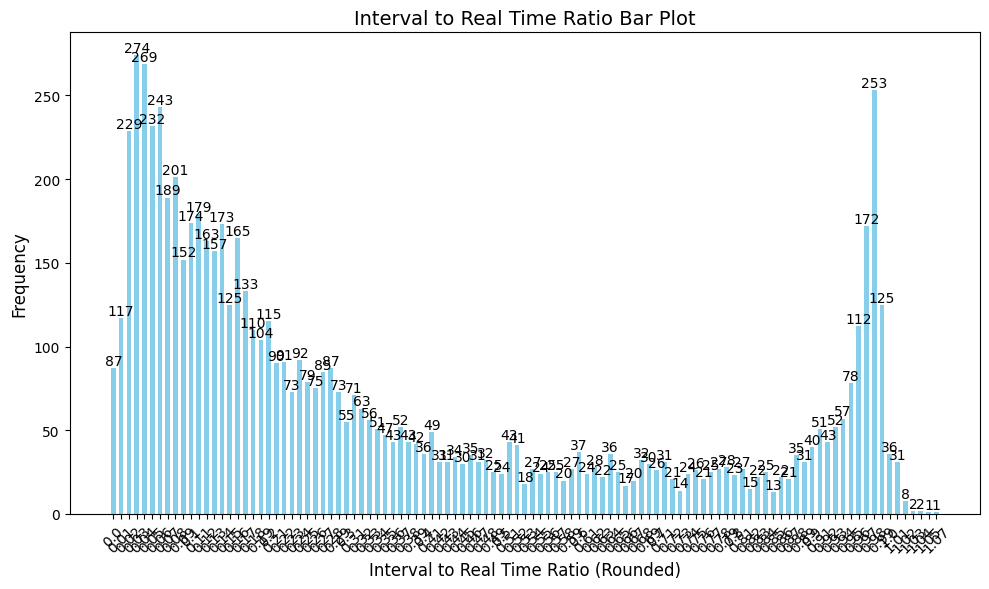

In [31]:
# 'interval_to_real_time_ratio' 열의 값들을 소수점 셋째 자리까지 반올림
data_last['rounded_ratio'] = data_last['interval_to_real_time_ratio'].round(2)

# 각 반올림된 값들의 빈도를 계산
ratio_counts = data_last['rounded_ratio'].value_counts().sort_index()

# 바 플롯 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(ratio_counts.index.astype(str), ratio_counts.values, color='skyblue', width=0.6)

# 플롯 제목 및 레이블 설정
plt.title('Interval to Real Time Ratio Bar Plot', fontsize=14)
plt.xlabel('Interval to Real Time Ratio (Rounded)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축 레이블 회전 및 폰트 크기 조정
x_ticks = np.arange(0, 1.1, 0.1)
plt.xticks(rotation=45, fontsize=10)

# 각 막대 위에 빈도 수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10)

# 플롯 보여주기
plt.tight_layout()
plt.show()

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_18748\885233497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['binned_ratio'] = pd.cut(data_last['interval_to_real_time_ratio'], bins)


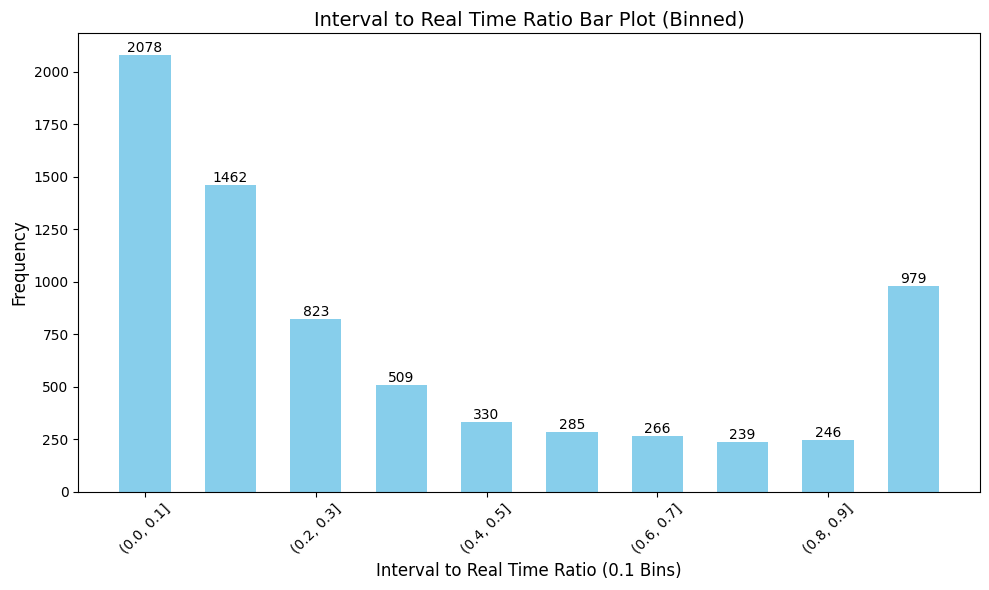

In [32]:
# 0에서 1까지 0.1 단위로 구간 나누기
bins = np.arange(0, 1.1, 0.1)
data_last['binned_ratio'] = pd.cut(data_last['interval_to_real_time_ratio'], bins)

# 각 구간에 해당하는 빈도 계산
ratio_counts = data_last['binned_ratio'].value_counts().sort_index()

# 바 플롯 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(ratio_counts.index.astype(str), ratio_counts.values, color='skyblue', width=0.6)

# 플롯 제목 및 레이블 설정
plt.title('Interval to Real Time Ratio Bar Plot (Binned)', fontsize=14)
plt.xlabel('Interval to Real Time Ratio (0.1 Bins)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축 레이블 설정 (간격을 두고 표시)
plt.xticks(np.arange(0, len(ratio_counts), step=2), ratio_counts.index[::2], rotation=45, fontsize=10)

# 각 막대 위에 빈도 수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10)

# 플롯 보여주기
plt.tight_layout()
plt.show()

## 현실 게임 비율 통계치

In [33]:
data_last['interval_to_real_time_ratio'].mean()

0.3524258824045209

In [34]:
data_last['interval_to_real_time_ratio'].median()

0.21062759336099568

In [36]:
data_last['interval_to_real_time_ratio'].std()

0.3308737080772787

In [38]:
# 25%, 50%, 75% 값 계산
quantiles = data_last['interval_to_real_time_ratio'].quantile([0.25, 0.5, 0.75])

# 결과 출력
print("25%, 50%, 75% quantiles:")
quantiles

25%, 50%, 75% quantiles:


0.25    0.083944
0.50    0.210628
0.75    0.591984
Name: interval_to_real_time_ratio, dtype: float64

In [39]:
# 평균 계산
mean_value = data_last['interval_to_real_time_ratio'].mean()

# 평균보다 큰 값 필터링 후 개수 세기
higher_than_mean_count = len(data_last[data_last['interval_to_real_time_ratio'] > mean_value])
higher_than_mean_count

2611

In [40]:
# 평균 계산
mean_value = data_last['interval_to_real_time_ratio'].median()

# 평균보다 큰 값 필터링 후 개수 세기
higher_than_mean_count = len(data_last[data_last['interval_to_real_time_ratio'] > mean_value])
higher_than_mean_count

3639

In [52]:
# 'interval_to_real_time_ratio' 컬럼의 최대값 구하기
max_ratio = data_last['interval_to_real_time_ratio'].max()

# 최대값을 가진 데이터 필터링
max_ratio_data = data_last[data_last['interval_to_real_time_ratio'] == max_ratio]

# 결과 출력
max_ratio_data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio
410255,2022-03-04T09:39:24.756Z,합격하자,114,1,0.0,8.0,114,complete,99,100,...,3.288333,0,2.649444,2.649444,0.005336,8.927695,8.927695,2022-03-04 21:18:20,2.453611,1.071806


In [53]:
data[data['player_slug']=='2022-03-08T06:59:00.410Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours
507771,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,1,2,...,True,10.578333,1,0.010833,2.565,0.029412,0.029412,7.254483,2022-03-10 10:24:38,2.526944
507772,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,2,3,...,True,10.578333,1,0.015278,2.565,0.020121,0.049532,7.254483,2022-03-10 10:24:53,2.526944
507773,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,3,4,...,True,10.578333,1,0.023056,2.565,0.032566,0.082099,7.254483,2022-03-10 10:25:20,2.526944
507774,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,4,5,...,True,10.578333,1,0.034722,2.565,0.067597,0.149696,7.254483,2022-03-10 10:26:01,2.526944
507775,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,5,6,...,True,10.578333,1,0.048889,2.565,0.049483,0.199178,7.254483,2022-03-10 10:26:51,2.526944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507865,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,95,96,...,True,10.578333,1,2.280278,2.565,0.001481,7.091295,7.254483,2022-03-10 12:39:14,2.526944
507866,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,96,97,...,True,10.578333,1,2.282222,2.565,0.001975,7.093270,7.254483,2022-03-10 12:39:20,2.526944
507867,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,97,98,...,True,10.578333,1,2.392778,2.565,0.095401,7.188670,7.254483,2022-03-10 12:45:57,2.526944
507868,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,98,99,...,True,10.578333,1,2.478333,2.565,0.040283,7.228954,7.254483,2022-03-10 12:51:04,2.526944


In [54]:
check=data[data['player_slug']=='2022-03-08T06:59:00.410Z']
check[['level_from','level_to','interval','interval_until','interval_tot','real_time_difference_in_hours']].tail(50)

,level_from,level_to,interval,interval_until,interval_tot,real_time_difference_in_hours
507820,50,51,0.030000,0.874444,2.565,2.526944
507821,51,52,0.021111,0.895556,2.565,2.526944
507822,52,53,0.048611,0.944167,2.565,2.526944
507823,53,54,0.019167,0.963333,2.565,2.526944
507824,54,55,0.003889,0.967222,2.565,2.526944
507825,55,56,0.026667,0.993889,2.565,2.526944
507826,56,57,0.026667,1.020556,2.565,2.526944
507827,57,58,0.026944,1.047500,2.565,2.526944
507828,58,59,0.020556,1.068056,2.565,2.526944
507829,59,60,0.032778,1.100833,2.565,2.526944


In [55]:
data_dir="../levelups_panel_20240305.csv"
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]

In [56]:
data[data['player_slug']=='2022-03-08T06:59:00.410Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,event_datetime_prev,interval,interval_cum,playtime_boss,playtime_dungeon,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side
1908299,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,1,2,...,2022-03-10 10:24:00,0.010833,0.010833,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908300,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,2,3,...,2022-03-10 10:24:38,0.004444,0.015278,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908301,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,3,4,...,2022-03-10 10:24:53,0.007778,0.023056,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908302,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,4,5,...,2022-03-10 10:25:20,0.011667,0.034722,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908303,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,5,6,...,2022-03-10 10:26:01,0.014167,0.048889,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908393,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,95,96,...,2022-03-10 12:39:08,0.001944,2.280278,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908394,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,96,97,...,2022-03-10 12:39:14,0.001944,2.282222,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908395,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,97,98,...,2022-03-10 12:39:20,0.110556,2.392778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1908396,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,98,99,...,2022-03-10 12:45:57,0.085556,2.478333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
